# Awaaz AI Model Demo

## Road Pothole Severity Detection

This notebook demonstrates:
1. Dataset loading and visualization
2. Model architecture overview
3. Testing with severe pothole images
4. Model predictions and confidence scores

## 1. Import Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys

# Add src directory to path
sys.path.insert(0, os.path.abspath('src'))

from src.models.model import PotholeSeverityModel
from src.data.dataset import PotholeImageDataset, CLASS_NAMES

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

Libraries imported successfully!
PyTorch version: 2.9.0
CUDA available: False
MPS available: True


## 2. Dataset Overview

In [2]:
dataset_path = "dataset"

train_dataset = PotholeImageDataset(
    data_dir=dataset_path,
    split="train",
    image_size=224,
    augment=False
)

print(f"Total training samples: {len(train_dataset)}")
print(f"Classes: {CLASS_NAMES}")

class_counts = {name: 0 for name in CLASS_NAMES}
for _, label in train_dataset.samples:
    class_counts[CLASS_NAMES[label]] += 1

print("\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

Loaded 10226 samples for train split
Class distribution: {'minor': 1146, 'moderate': 6662, 'severe': 1958, 'good': 460}
Total training samples: 10226
Classes: ['good', 'minor', 'moderate', 'severe']

Class Distribution:
  good: 460 images
  minor: 1146 images
  moderate: 6662 images
  severe: 1958 images


## 3. Model Architecture

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PotholeSeverityModel(num_classes=4, pretrained=True)
print("\n Model Architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n Total parameters: {total_params:,}")

Using device: mps



 Model Architecture:
PotholeSeverityModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, 

## 4. Load Trained Model

In [4]:
checkpoint_path = "checkpoints/best.pt"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if "model_state" in checkpoint:
        model.load_state_dict(checkpoint["model_state"])
    elif "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
    else:
        model.load_state_dict(checkpoint)
    
    model.to(device)
    model.eval()
    print("Model loaded successfully!")
    if "epoch" in checkpoint:
        print(f"Trained for {checkpoint.get('epoch', 0)} epochs")
    if "best_val_acc" in checkpoint:
        print(f"Best validation accuracy: {checkpoint.get('best_val_acc', 0):.4f}")
else:
    print("Checkpoint not found. Using untrained model.")

Model loaded successfully!
Trained for 5 epochs
Best validation accuracy: 0.3488


## 5. Test with Severe Pothole Image

Test image: UnPavedRoad__719.jpg


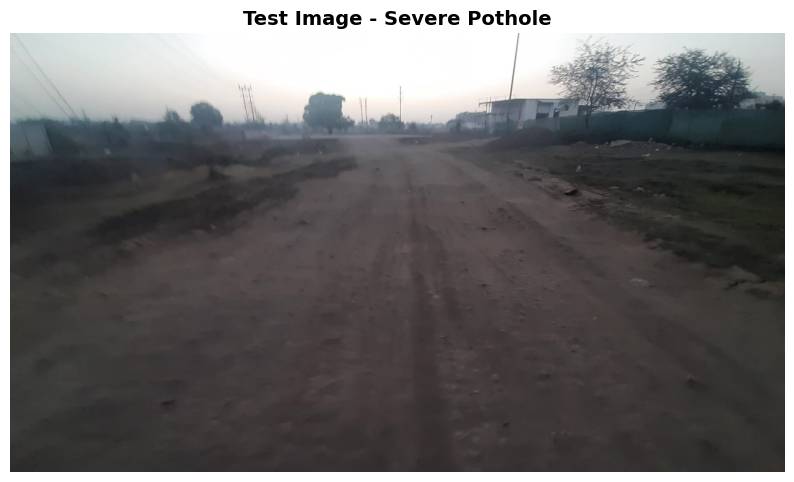


Prediction: SEVERE
Confidence: 0.9001

Class Probabilities:
  good: 0.0003 (0.03%)
  minor: 0.0001 (0.01%)
  moderate: 0.0995 (9.95%)
  severe: 0.9001 (90.01%)


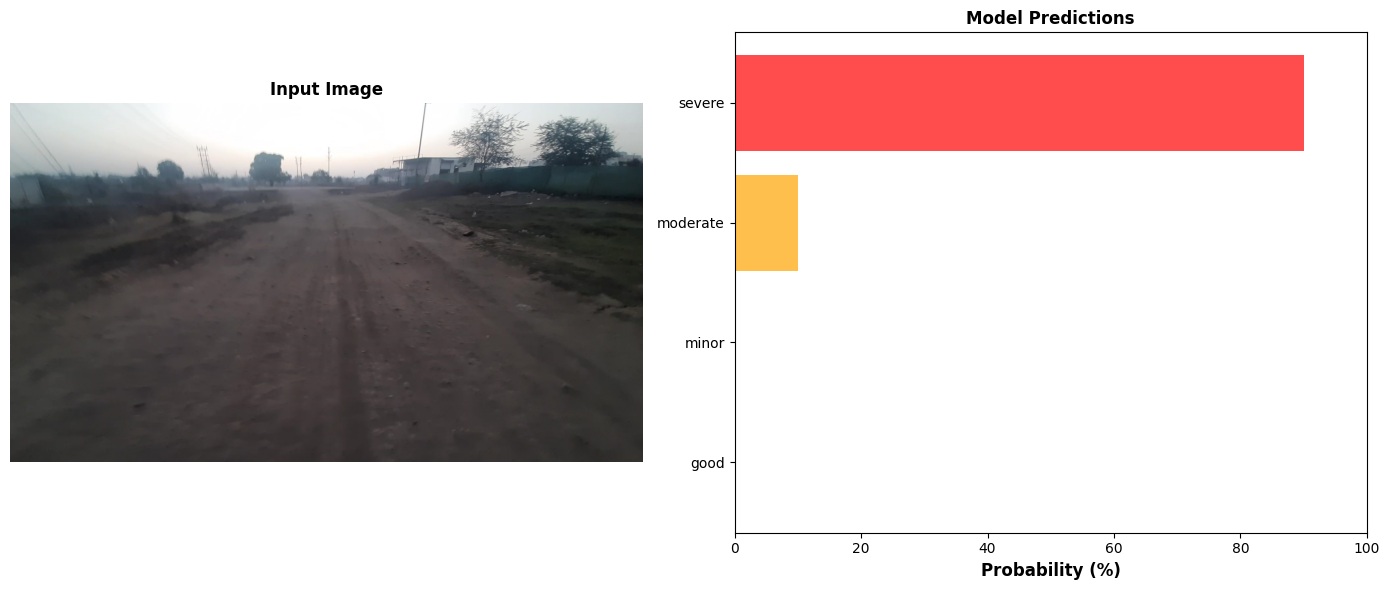


DANGEROUS ROAD DETECTED! Requires IMMEDIATE attention.


In [5]:
severe_dir = "dataset/data/potholes/test/severe"

if os.path.exists(severe_dir):
    severe_images = [f for f in os.listdir(severe_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    
    if severe_images:
        test_image_path = os.path.join(severe_dir, severe_images[0])
        print(f"Test image: {severe_images[0]}")
        
        image = Image.open(test_image_path).convert("RGB")
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.title("Test Image - Severe Pothole", fontsize=14, fontweight="bold")
        plt.axis("off")
        plt.show()
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            probs = probabilities[0].cpu().numpy()
            predicted_class = CLASS_NAMES[predicted.item()]
            confidence_score = confidence.item()
        
        print(f"\nPrediction: {predicted_class.upper()}")
        print(f"Confidence: {confidence_score:.4f}")
        print(f"\nClass Probabilities:")
        for i, class_name in enumerate(CLASS_NAMES):
            print(f"  {class_name}: {probs[i]:.4f} ({probs[i]*100:.2f}%)")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.imshow(image)
        ax1.set_title("Input Image", fontsize=12, fontweight="bold")
        ax1.axis("off")
        ax2.barh(CLASS_NAMES, probs * 100, color=["green", "yellow", "orange", "red"], alpha=0.7)
        ax2.set_xlabel("Probability (%)", fontsize=12, fontweight="bold")
        ax2.set_title("Model Predictions", fontsize=12, fontweight="bold")
        ax2.set_xlim(0, 100)
        plt.tight_layout()
        plt.show()
        
        if predicted_class == "severe":
            print("\nDANGEROUS ROAD DETECTED! Requires IMMEDIATE attention.")
    else:
        print("No severe images found")